In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import cv2
import sys
import os
import glob

sys.path.insert(0, '..')

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sympy.utilities.iterables import multiset_permutations
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)
from sklearn.metrics import (cohen_kappa_score, confusion_matrix, classification_report, f1_score)
from MulticoreTSNE import MulticoreTSNE as MTSNE

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [2]:
# from fcn8s import Inference
# SNAPSHOT = '../fcn8s/10x/snapshots/fcn.ckpt-82585'
from densenet_small import Inference
SNAPSHOT = '../densenet_small/10x/snapshots/densenet.ckpt-30845'; MODEL_NAME='DensenetSmall'
# from densenet import Inference
# SNAPSHOT = '../densenet/10x/snapshots/densenet.ckpt-55800'; MODEL_NAME='Densenet'
# from unet import Inference
# SNAPSHOT = '../unet/10x/snapshots/unet.ckpt-58900'; MODEL_NAME='UNet'

# config = tf.ConfigProto()
config = tf.ConfigProto( device_count = {'GPU': 0} )
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Inference(sess=sess, x_dims = [256, 256, 3])
model.restore(SNAPSHOT)

Requesting 4 dense blocks
MINIMIUM DIMENSION:  8
Setting up densenet in inference mode
DenseNet Model
Non-linearity: <function selu at 0x7f107fdcaed8>
	 x_in (?, 256, 256, 3)
Dense block #0 (dd)
	 Transition Down with k_out= 96
Dense block #1 (dd)
	 Transition Down with k_out= 144
Dense block #2 (dd)
	 Transition Down with k_out= 240
Dense block #3 (dense)
	 Bottleneck:  (?, 8, 8, 528)
	 Transition Up with k_out= 264
Dense block #0 (du)
	 Transition Up with k_out= 96
Dense block #1 (du)
	 Transition Up with k_out= 48
Dense block #2 (du)
Model output y_hat: (?, 256, 256, 5)
Restoring from ../densenet_small/10x/snapshots/densenet.ckpt-30845
INFO:tensorflow:Restoring parameters from ../densenet_small/10x/snapshots/densenet.ckpt-30845
Success!


## Single images; close to x-space

In [3]:
# Initialize data structures-- run again to reset
jpg_list = sorted(glob.glob('../data/train_jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/train_mask/*.png'))
img = cv2.imread(jpg_list[0])[:,:,::-1]
img = img[128:640, 128:640, :]
img = cv2.resize(img, dsize=(0,0), fx=0.5, fy=0.5)
img = np.expand_dims(img, 0)

mask = cv2.imread(mask_list[0], -1)
mask = mask[128:640, 128:640]
mask = cv2.resize(mask, dsize=(0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)

z_dict = {}
z_shape_dict = {}
y_dict = {}
y_shape_dict = {}
x_dict = {}

for key, op in model.intermediate_ops.items():
    ret = sess.run(op, {model.x_in: img, model.keep_prob: 1.0})

    retshape = ret.shape
    print(retshape)
    zshape = [retshape[1] * retshape[2], retshape[-1]]
    z_dict[key] = np.empty(shape=(0, retshape[-1]))
    x_dict[key] = np.empty(shape=(0, retshape[-1]))
    z_shape_dict[key] = zshape
    y_dict[key] = np.empty(shape=(0, 1), dtype=np.int)
    y_shape_dict[key] = [retshape[1], retshape[2]]
    
for key in sorted(z_dict.keys()):
    print(key, y_dict[key], z_dict[key], z_shape_dict[key], y_shape_dict[key])

(1, 8, 8, 240)
(1, 16, 16, 144)
(1, 8, 8, 528)
(1, 64, 64, 96)
(1, 64, 64, 96)
(1, 32, 32, 96)
(1, 16, 16, 192)
(1, 32, 32, 96)
(1, 64, 64, 48)
01. Conv1 [] [] [4096, 48] [64, 64]
02. Down0 [] [] [1024, 96] [32, 32]
03. Down1 [] [] [256, 144] [16, 16]
04. Down2 [] [] [64, 240] [8, 8]
05. Bottleneck [] [] [64, 528] [8, 8]
06. Up0 [] [] [256, 192] [16, 16]
07. Up1 [] [] [1024, 96] [32, 32]
08. Up2 [] [] [4096, 96] [64, 64]
09. y_hat_0 [] [] [4096, 96] [64, 64]


In [4]:
# Populate dicts
jpg_list = sorted(glob.glob('../data/val_jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/val_mask/*.png'))

x0 = 128
y0 = 128

# number of images to sample from
n = 20

imgs = zip(jpg_list, mask_list)
np.random.shuffle(imgs)

for jpg, mask in imgs[:n]:

    x = cv2.imread(jpg, -1)[:,:,::-1]
    y = cv2.imread(mask, -1)
    y_ = y[x0:x0+512, y0:y0+512]
    x_ = x[x0:x0+512, y0:y0+512]
    x_ = cv2.resize(x_, dsize=(0,0), fx=0.5, fy=0.5)
    x_ = x_ * (2/255.) - 1.
    x_ = np.expand_dims(x_, 0)
    print('{}: {}'.format(mask, np.unique(y_)))

    # Process image and get each op -- a little inefficient. Move to a list-based approach
    for key, op in model.intermediate_ops.items():
        ret = sess.run(op,  feed_dict={model.x_in: x_, model.keep_prob: 1.0})
        op_shape = z_shape_dict[key]
        ret_reshape = ret.reshape(op_shape)
        z_dict[key] = np.concatenate([z_dict[key], ret_reshape], axis=0)
        
        y_resize = cv2.resize(y_, dsize=tuple(y_shape_dict[key]), interpolation=cv2.INTER_NEAREST)
        y_resize = y_resize.reshape([np.prod(y_shape_dict[key]), 1]).astype(np.int)
        y_dict[key] = np.concatenate([y_dict[key], y_resize], axis=0)
        
for key in z_dict.keys():
    print(key, '\t', y_dict[key].shape, z_dict[key].shape, np.unique(y_dict[key]))


../data/val_mask/1305400_01228.png: [4]
../data/val_mask/1305463_1(4+5)_14_6.png: [1 4]
../data/val_mask/IngN-010_00154.png: [4]
../data/val_mask/1305400_00742.png: [4]
../data/val_mask/1305400_00800.png: [4]
../data/val_mask/IngN-010_00567.png: [4]
../data/val_mask/IngN-010_00560.png: [4]
../data/val_mask/1305400_01330.png: [4]
../data/val_mask/test40.png: [3 4]
../data/val_mask/test157.png: [0 1 4]
../data/val_mask/test118.png: [0 1 4]
../data/val_mask/1305400_00849.png: [4]
../data/val_mask/1305400_01132.png: [4]
../data/val_mask/test223.png: [0 1 3 4]
../data/val_mask/1305400_01484.png: [4]
../data/val_mask/test17.png: [0 1 3 4]
../data/val_mask/test150.png: [1 4]
../data/val_mask/1305400_1(4+5)_3_12.png: [2 4]
../data/val_mask/1305466_1(4+5)_3_13.png: [1 4]
../data/val_mask/test177.png: [0 1 4]
04. Down2 	 (1280, 1) (1280, 240) [0 1 2 3 4]
03. Down1 	 (5120, 1) (5120, 144) [0 1 2 3 4]
06. Up0 	 (5120, 1) (5120, 192) [0 1 2 3 4]
05. Bottleneck 	 (1280, 1) (1280, 528) [0 1 2 3 4]
08

In [5]:
# Gather alike classes and project each layer 
y_plot = []
n_sample = 1000

for k in range(5):
    for key in z_dict.keys():
        y_key = y_dict[key]
        z_key = z_dict[key]
        x_key = x_dict[key]
        
        # Sample an equal number from each class
        # careful. if there's few in one class it will repeat
        z_key_class = z_key[np.squeeze(y_key) == k, :]
        n_z = z_key_class.shape[0]
        idxs = np.arange(n_z)
        z_choice = z_key_class[np.random.choice(idxs, n_sample), :]
        x_key = np.concatenate([x_key, z_choice], axis=0)
        x_dict[key] = x_key
        
    y_plot += [k]*n_sample
        
y_plot = np.asarray(y_plot)

In [6]:
# Cluster and project into 2D
manifold_dict = {} # To hold projections
clustered_dict = {} # To hold clustered labels
manifolder = MTSNE(n_components=2, n_jobs=12)
for key, vals in sorted(x_dict.items()):
    print(key, '\t', vals.shape)
    
    # Cluster and find the best class alignment
    best_kappa = 0.0
    best_f1 = 0.0
    best_remapped = None
    clusterer = MiniBatchKMeans(n_clusters=5, n_init=100).fit(vals)
    clustered = clusterer.labels_
    for perm in multiset_permutations(range(5)):
        mapping = {x: k for x, k in zip(range(5), perm)}
        clustered_remapped = np.asarray([mapping[y] for y in clustered])
        kappa = cohen_kappa_score(y_plot, clustered_remapped)
        f1 = f1_score(y_plot, clustered_remapped, average='macro')
#         if f1 > best_f1:
        if kappa > best_kappa:
            best_remapped = clustered_remapped
            best_kappa = kappa
            best_f1 = f1
            
    print(best_kappa, best_f1)
    print(classification_report(y_plot, best_remapped), end='\n\n')
    
    pr0 = manifolder.fit_transform(vals)
    manifold_dict[key] = pr0 
    clustered_dict[key] = [best_remapped, best_kappa, best_f1]

01. Conv1 	 (5000, 48)
0.33025000000000004 0.47192819953448045
             precision    recall  f1-score   support

          0       0.32      0.45      0.37      1000
          1       0.32      0.42      0.37      1000
          2       0.85      0.63      0.72      1000
          3       0.50      0.26      0.34      1000
          4       0.55      0.56      0.55      1000

avg / total       0.51      0.46      0.47      5000


02. Down0 	 (5000, 96)
0.31125 0.43678699070182325
             precision    recall  f1-score   support

          0       0.36      0.21      0.26      1000
          1       0.31      0.44      0.36      1000
          2       0.61      0.67      0.64      1000
          3       0.45      0.29      0.35      1000
          4       0.50      0.64      0.56      1000

avg / total       0.45      0.45      0.44      5000


03. Down1 	 (5000, 144)
0.35850000000000004 0.4870472456746036
             precision    recall  f1-score   support

          0       0

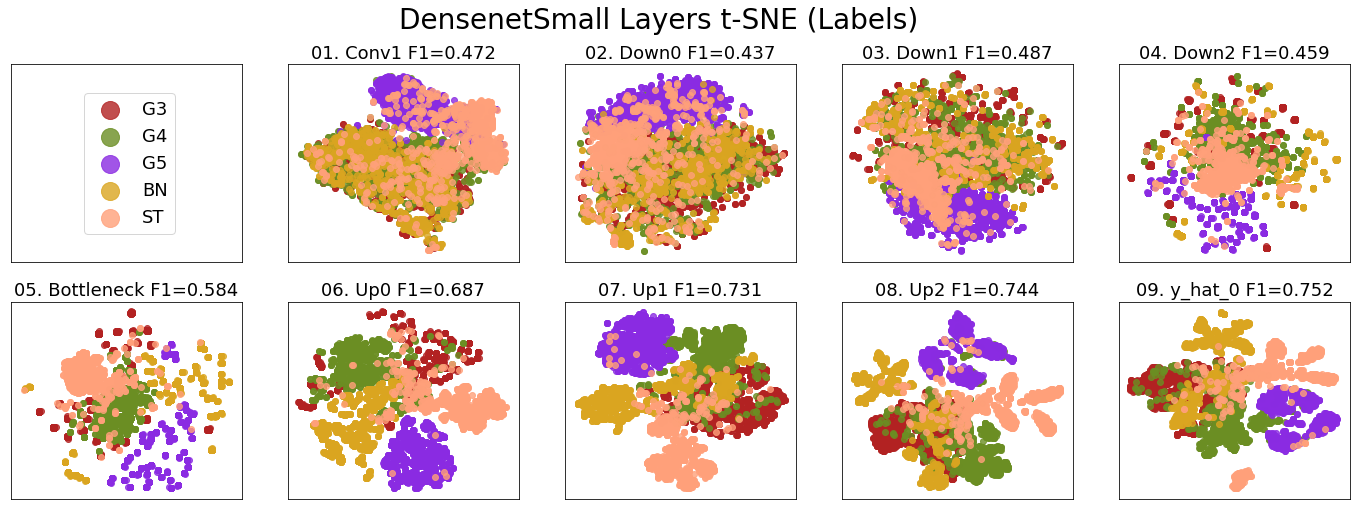

In [14]:
n_cols = len(manifold_dict.keys()) / 2 + (len(manifold_dict.keys()) % 2)
fig, axs = plt.subplots(2, n_cols, figsize=(24, 8))
axs = axs.flatten()

if (len(manifold_dict.keys())) % 2 > 0:
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs = axs[1:]
    
for k in range(5):
    for key, ax in zip(sorted(manifold_dict.keys()), axs):
        idxs = np.squeeze(np.where(y_plot==k))
#         idxs = np.squeeze(np.where(clustered_dict[key][0] == k))

        ax.set_title('{} F1={:3.3f}'.format(key, clustered_dict[key][2]), fontsize=18)
        
        xs = manifold_dict[key][idxs, 0]
        ys = manifold_dict[key][idxs, 1]
        
#         sns.regplot(xs, ys, fit_reg=False, color=colors[k], label=labels[k], ax=ax, scatter_kws={'alpha': 0.1})
        sns.regplot(xs, ys, fit_reg=False, color=colors[k], label=labels[k], ax=ax)
        ax.set_yticks([])
        ax.set_xticks([])
        
axs[0].legend(markerscale=3., bbox_to_anchor=(-0.45, 0.9), fontsize=18)

plt.suptitle('{} Layers t-SNE (Labels)'.format(MODEL_NAME), fontsize=28)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_layers_tsne.pdf'.format(MODEL_NAME), bbox_inches='tight')

# plt.suptitle('{} Layers t-SNE (Clusters)'.format(MODEL_NAME), fontsize=28)
# plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_layers_tsne_cluster_colors.pdf'.format(MODEL_NAME), bbox_inches='tight')